In [1]:
import pandas as pd

In [20]:
fields = [
    'V01301',    # 站号
    'VF01015_CN',# 站点名称
    'V_CITY',    # 所属地市
    'V_COUNTY',  # 所属县
    'V06001',    # 经度
    'V05001',    # 纬度
    'V07001',    # 海拔
    'V20001',    # 能见度
    'V13003'     # 相对湿度
]
df_nation = pd.read_csv('../data/SurfAuto_20250228000000.csv', encoding='gbk', na_values=9999, usecols=fields)
fields_2 = [
    'V01301',    # 站号
    'VF01015_CN',# 站点名称
    'V_CITY',    # 所属地市
    'V_COUNTY',  # 所属县
    'V06001',    # 经度
    'V05001',    # 纬度
    'V07001',    # 海拔
    'V13003'     # 相对湿度
]
df_region = pd.read_csv('../data/SurfAwst_20250228000000.csv', encoding='gbk', na_values=9999, usecols=fields_2)
# 重命名字段为英文名
field_map = {
    'V01301': 'code',
    'VF01015_CN': 'name',
    'V_CITY': 'city',
    'V_COUNTY': 'county',
    'V06001': 'lon',
    'V05001': 'lat',
    'V07001': 'altitude',
    'V20001': 'vis',
    'V13003': 'rh'
}

df_nation = df_nation.rename(columns=field_map)
df_region = df_region.rename(columns=field_map)
# 去除掉df_region中rh为NaN的条目
df_region = df_region.dropna(subset=['rh', 'county'])
print(df_nation.head())
print(df_region.count())

    code     lat      lon  altitude  rh   vis       name   county city
0  57988  25.110  113.345     143.2  96   800  乐昌国家基本气象站      乐昌市   韶关
1  57989  25.059  113.763     112.7  96   200  仁化国家基本气象站      仁化县   韶关
2  57996  25.081  114.255     149.7  95  1900  南雄国家基准气候站      南雄市   韶关
3  59071  24.732  112.278     174.3  94  2700  连南国家基本气象站  连南瑶族自治县   清远
4  59072  24.811  112.371     131.7  98   100     连州市气象局      连州市   清远
code        1243
lon         1243
lat         1243
altitude    1243
county      1243
city        1243
name        1243
rh          1243
dtype: int64


In [13]:
station_vis = df_nation
station_rh = df_region

In [14]:
import numpy as np
from scipy.spatial.distance import cdist

# 查看数据的基本信息
print("有能见度数据的站点数量:", len(station_vis))
print("只有湿度数据的站点数量:", len(station_rh))
print("\nstation_vis 样本数据:")
print(station_vis.head())
print("\nstation_rh 样本数据:")
print(station_rh.head())


有能见度数据的站点数量: 87
只有湿度数据的站点数量: 1243

station_vis 样本数据:
    code     lat      lon  altitude  rh   vis       name   county city
0  57988  25.110  113.345     143.2  96   800  乐昌国家基本气象站      乐昌市   韶关
1  57989  25.059  113.763     112.7  96   200  仁化国家基本气象站      仁化县   韶关
2  57996  25.081  114.255     149.7  95  1900  南雄国家基准气候站      南雄市   韶关
3  59071  24.732  112.278     174.3  94  2700  连南国家基本气象站  连南瑶族自治县   清远
4  59072  24.811  112.371     131.7  98   100     连州市气象局      连州市   清远

station_rh 样本数据:
     code         lon        lat  altitude county city               name  \
12  G9577  113.234722  23.116944       8.6    荔湾区   广州        荔湾区多宝街永庆坊二期   
14  G7516  110.331944  20.703056       7.0    雷州市   湛江        雷州塘村渔港气象观测站   
27  G5107  115.577200  24.524400     263.8    兴宁市   梅州      兴宁市罗浮镇国家气象观测站   
28  G7441  110.220000  20.452500     126.3    徐闻县   湛江    徐闻县下桥镇南华农场气象观测站   
36  G9034  116.484900  22.937200       9.8    惠来县   揭阳  惠来石碑山应用气象观测站（海洋）2   

       rh  
12   83.0  
14  100.0  
27  

In [15]:
def find_nearest_stations(target_coords, reference_coords, k=4):
    """
    找到最近的k个站点
    
    Parameters:
    target_coords: 目标站点坐标 (lat, lon)
    reference_coords: 参考站点坐标数组 [(lat1, lon1), (lat2, lon2), ...]
    k: 最近邻站点数量
    
    Returns:
    nearest_indices: 最近站点的索引
    nearest_distances: 对应的距离
    """
    # 计算距离矩阵（使用欧几里得距离，单位：度）
    distances = cdist([target_coords], reference_coords, metric='euclidean')[0]
    
    # 找到最近的k个站点
    nearest_indices = np.argsort(distances)[:k]
    nearest_distances = distances[nearest_indices]
    
    return nearest_indices, nearest_distances

def calculate_visibility_by_humidity(target_rh, nearest_stations_data):
    """
    基于相对湿度计算能见度
    
    Parameters:
    target_rh: 目标站点的相对湿度
    nearest_stations_data: 最近邻站点的数据 (包含rh和vis列)
    
    Returns:
    vis_rh: 基于湿度权重的能见度估算值
    """
    # 过滤掉湿度或能见度为NaN的站点
    valid_stations = nearest_stations_data.dropna(subset=['rh', 'vis'])
    
    if len(valid_stations) == 0:
        return np.nan
    
    # 计算湿度差
    rh_diff = np.abs(target_rh - valid_stations['rh'].values)
    
    # 避免除零，设置最小差值
    rh_diff = np.maximum(rh_diff, 0.1)
    
    # 计算湿度权重 w_rh_i = 1/(d_rh_i)^2
    w_rh = 1.0 / (rh_diff ** 2)
    
    # 加权平均
    vis_rh = np.sum(w_rh * valid_stations['vis'].values) / np.sum(w_rh)
    
    return vis_rh

def calculate_visibility_by_distance(nearest_distances, nearest_stations_vis):
    """
    基于距离计算能见度
    
    Parameters:
    nearest_distances: 到最近邻站点的距离数组
    nearest_stations_vis: 最近邻站点的能见度数组
    
    Returns:
    vis_dis: 基于距离权重的能见度估算值
    """
    # 过滤掉能见度为NaN的站点
    valid_mask = ~np.isnan(nearest_stations_vis)
    valid_distances = nearest_distances[valid_mask]
    valid_vis = nearest_stations_vis[valid_mask]
    
    if len(valid_vis) == 0:
        return np.nan
    
    # 避免除零，设置最小距离
    valid_distances = np.maximum(valid_distances, 0.001)
    
    # 计算距离权重 w_dis_i = 1/(distance_i)^2
    w_dis = 1.0 / (valid_distances ** 2)
    
    # 加权平均
    vis_dis = np.sum(w_dis * valid_vis) / np.sum(w_dis)
    
    return vis_dis

print("能见度估算函数定义完成")


能见度估算函数定义完成


In [16]:
# 为station_rh中的站点估算能见度
station_rh_estimated = station_rh.copy()

# 准备坐标数据
vis_coords = station_vis[['lat', 'lon']].values
rh_coords = station_rh[['lat', 'lon']].values

# 初始化结果列表
vis_rh_results = []
vis_dis_results = []
vis_final_results = []

print("开始处理站点能见度估算...")
print(f"需要处理的站点数量: {len(station_rh)}")

# 对每个station_rh站点进行处理
for idx, row in station_rh.iterrows():
    target_coords = [row['lat'], row['lon']]
    target_rh = row['rh']
    
    # 找到最近的4个有能见度数据的站点
    nearest_indices, nearest_distances = find_nearest_stations(
        target_coords, vis_coords, k=4
    )
    
    # 获取最近邻站点的数据
    nearest_stations = station_vis.iloc[nearest_indices]
    
    # 基于相对湿度的能见度估算
    vis_rh = calculate_visibility_by_humidity(target_rh, nearest_stations)
    vis_rh_results.append(vis_rh)
    
    # 基于距离的能见度估算
    vis_dis = calculate_visibility_by_distance(
        nearest_distances, nearest_stations['vis'].values
    )
    vis_dis_results.append(vis_dis)
    
    # 最终能见度估算（两种方法的平均）
    if np.isnan(vis_rh) and np.isnan(vis_dis):
        vis_final = np.nan
    elif np.isnan(vis_rh):
        vis_final = vis_dis
    elif np.isnan(vis_dis):
        vis_final = vis_rh
    else:
        vis_final = 0.5 * vis_rh + 0.5 * vis_dis
    
    vis_final_results.append(vis_final)

# 将结果添加到数据框中
station_rh_estimated['vis_rh'] = vis_rh_results
station_rh_estimated['vis_dis'] = vis_dis_results
station_rh_estimated['vis'] = vis_final_results
station_rh_estimated['is_vis_est'] = 1

print("能见度估算完成!")
print(f"成功估算的站点数量: {np.sum(~np.isnan(vis_final_results))}")
print("\n估算结果样本:")
print(station_rh_estimated[['code', 'name', 'rh', 'vis_rh', 'vis_dis', 'vis']].head())


开始处理站点能见度估算...
需要处理的站点数量: 1243
能见度估算完成!
成功估算的站点数量: 1243

估算结果样本:
     code               name     rh       vis_rh      vis_dis          vis
12  G9577        荔湾区多宝街永庆坊二期   83.0  4624.295658  4875.257374  4749.776516
14  G7516        雷州塘村渔港气象观测站  100.0  1890.727465  2821.560505  2356.143985
27  G5107      兴宁市罗浮镇国家气象观测站  100.0   830.573248  1292.134072  1061.353660
28  G7441    徐闻县下桥镇南华农场气象观测站   96.0   307.755215  1061.258537   684.506876
36  G9034  惠来石碑山应用气象观测站（海洋）2   79.0  4645.871985  7356.423617  6001.147801


In [21]:
# 为station_vis添加标识列
station_vis_final = station_vis.copy()
station_vis_final['is_vis_est'] = 0  # 实测值

# 确保station_rh_estimated有相同的列结构
# 为了保持一致性，我们需要添加缺失的列
if 'vis_rh' not in station_vis_final.columns:
    station_vis_final['vis_rh'] = np.nan
if 'vis_dis' not in station_vis_final.columns:
    station_vis_final['vis_dis'] = np.nan

# 合并两个数据集
station_vis_all = pd.concat([station_vis_final, station_rh_estimated], 
                           ignore_index=True, sort=False)

# 重新排列列的顺序
column_order = ['code', 'name', 'city', 'county', 'lon', 'lat', 'altitude', 
                'rh', 'vis', 'vis_rh', 'vis_dis', 'is_vis_est']
station_vis_all = station_vis_all[column_order]

print("数据合并完成!")
print(f"最终数据集包含站点数量: {len(station_vis_all)}")
print(f"其中实测能见度站点: {len(station_vis_all[station_vis_all['is_vis_est'] == 0])}")
print(f"其中估算能见度站点: {len(station_vis_all[station_vis_all['is_vis_est'] == 1])}")

print("\n最终数据集样本:")
print(station_vis_all.head(10))


数据合并完成!
最终数据集包含站点数量: 1330
其中实测能见度站点: 87
其中估算能见度站点: 1243

最终数据集样本:
    code       name city     county      lon     lat  altitude    rh     vis  \
0  57988  乐昌国家基本气象站   韶关        乐昌市  113.345  25.110     143.2  96.0   800.0   
1  57989  仁化国家基本气象站   韶关        仁化县  113.763  25.059     112.7  96.0   200.0   
2  57996  南雄国家基准气候站   韶关        南雄市  114.255  25.081     149.7  95.0  1900.0   
3  59071  连南国家基本气象站   清远    连南瑶族自治县  112.278  24.732     174.3  94.0  2700.0   
4  59072     连州市气象局   清远        连州市  112.371  24.811     131.7  98.0   100.0   
5  59074     连山县气象局   清远  连山壮族瑶族自治县  112.073  24.573     300.6  86.0  4000.0   
6  59075     阳山县气象局   清远        阳山县  112.570  24.295     155.2  96.0   100.0   
7  59081  乳源国家基本气象站   韶关    乳源瑶族自治县  113.288  24.784     125.3  95.0  1400.0   
8  59082  韶关国家基本气象站   韶关        曲江区  113.608  24.671     121.3  94.0  6800.0   
9  59087  佛冈国家基本气象站   清远        佛冈县  113.523  23.881      97.2  95.0  3300.0   

   vis_rh  vis_dis  is_vis_est  
0     NaN      NaN  

In [22]:
# 统计分析
print("=== 能见度估算结果统计分析 ===")

# 实测能见度统计
vis_measured = station_vis_all[station_vis_all['is_vis_est'] == 0]['vis']
print(f"\n实测能见度统计:")
print(f"数量: {len(vis_measured)}")
print(f"平均值: {vis_measured.mean():.1f}")
print(f"中位数: {vis_measured.median():.1f}")
print(f"标准差: {vis_measured.std():.1f}")
print(f"最小值: {vis_measured.min():.1f}")
print(f"最大值: {vis_measured.max():.1f}")

# 估算能见度统计
vis_estimated = station_vis_all[station_vis_all['is_vis_est'] == 1]['vis'].dropna()
print(f"\n估算能见度统计:")
print(f"数量: {len(vis_estimated)}")
print(f"平均值: {vis_estimated.mean():.1f}")
print(f"中位数: {vis_estimated.median():.1f}")
print(f"标准差: {vis_estimated.std():.1f}")
print(f"最小值: {vis_estimated.min():.1f}")
print(f"最大值: {vis_estimated.max():.1f}")

# 两种估算方法的比较
vis_rh_values = station_vis_all[station_vis_all['is_vis_est'] == 1]['vis_rh'].dropna()
vis_dis_values = station_vis_all[station_vis_all['is_vis_est'] == 1]['vis_dis'].dropna()

print(f"\n基于湿度的估算结果:")
print(f"平均值: {vis_rh_values.mean():.1f}")
print(f"标准差: {vis_rh_values.std():.1f}")

print(f"\n基于距离的估算结果:")
print(f"平均值: {vis_dis_values.mean():.1f}")
print(f"标准差: {vis_dis_values.std():.1f}")

# 数据质量检查
print(f"\n=== 数据质量检查 ===")
nan_count = station_vis_all['vis'].isna().sum()
print(f"能见度缺失值数量: {nan_count}")
print(f"数据完整率: {(len(station_vis_all) - nan_count) / len(station_vis_all) * 100:.1f}%")


=== 能见度估算结果统计分析 ===

实测能见度统计:
数量: 87
平均值: 4226.4
中位数: 3900.0
标准差: 3939.7
最小值: 0.0
最大值: 30000.0

估算能见度统计:
数量: 1243
平均值: 4914.7
中位数: 5061.2
标准差: 2148.0
最小值: 208.3
最大值: 20077.1

基于湿度的估算结果:
平均值: 4737.1
标准差: 2418.4

基于距离的估算结果:
平均值: 5092.2
标准差: 2299.6

=== 数据质量检查 ===
能见度缺失值数量: 0
数据完整率: 100.0%


In [23]:
# 保存结果到CSV文件
output_file = '../data/station_vis_all_estimated.csv'
station_vis_all.to_csv(output_file, index=False, encoding='utf-8-sig')
print(f"结果已保存到: {output_file}")

# 显示最终结果的总结
print("\n=== 最终结果总结 ===")
print(f"总站点数: {len(station_vis_all)}")
print(f"实测能见度站点: {len(station_vis_all[station_vis_all['is_vis_est'] == 0])}")
print(f"估算能见度站点: {len(station_vis_all[station_vis_all['is_vis_est'] == 1])}")

print("\n算法执行完成！您现在拥有了一个包含所有站点能见度信息的完整数据集。")
print("- 'is_vis_est' = 0: 实测能见度值")
print("- 'is_vis_est' = 1: 估算能见度值")
print("- 'vis_rh': 基于相对湿度的估算值")
print("- 'vis_dis': 基于距离的估算值")
print("- 'vis': 最终能见度值（实测值或两种估算方法的平均值）")


结果已保存到: ../data/station_vis_all_estimated.csv

=== 最终结果总结 ===
总站点数: 1330
实测能见度站点: 87
估算能见度站点: 1243

算法执行完成！您现在拥有了一个包含所有站点能见度信息的完整数据集。
- 'is_vis_est' = 0: 实测能见度值
- 'is_vis_est' = 1: 估算能见度值
- 'vis_rh': 基于相对湿度的估算值
- 'vis_dis': 基于距离的估算值
- 'vis': 最终能见度值（实测值或两种估算方法的平均值）


In [24]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm
import numpy as np

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

print("导入绘图库完成")


导入绘图库完成


In [25]:
def create_visibility_map(data, title, ax, show_colorbar=True):
    """
    创建能见度地图
    
    Parameters:
    data: 包含lon, lat, vis列的DataFrame
    title: 图表标题
    ax: matplotlib轴对象
    show_colorbar: 是否显示颜色条
    """
    # 过滤掉缺失值
    valid_data = data.dropna(subset=['vis', 'lon', 'lat'])
    
    if len(valid_data) == 0:
        ax.text(0.5, 0.5, '无有效数据', transform=ax.transAxes, 
                ha='center', va='center', fontsize=14)
        return
    
    # 设置地图投影和范围
    ax.set_extent([108, 118, 20, 26], crs=ccrs.PlateCarree())
    
    # 添加地图要素
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.add_feature(cfeature.LAND, alpha=0.3, color='lightgray')
    ax.add_feature(cfeature.OCEAN, alpha=0.3, color='lightblue')
    
    # 添加网格线
    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    
    # 定义能见度等级和颜色
    vis_levels = [0, 200, 500, 1000, 2000, 5000, 10000, 20000]
    colors = ['darkred', 'red', 'orange', 'yellow', 'lightgreen', 'green', 'darkgreen']
    
    # 创建散点图
    scatter = ax.scatter(valid_data['lon'], valid_data['lat'], 
                        c=valid_data['vis'], s=30, alpha=0.8,
                        cmap='RdYlGn', vmin=0, vmax=10000,
                        transform=ccrs.PlateCarree(), edgecolors='black', linewidth=0.3)
    
    # 添加颜色条
    if show_colorbar:
        cbar = plt.colorbar(scatter, ax=ax, shrink=0.8, pad=0.02)
        cbar.set_label('能见度 (m)', fontsize=10)
        cbar.ax.tick_params(labelsize=8)
    
    ax.set_title(title, fontsize=12, fontweight='bold')
    
    return scatter

print("绘图函数定义完成")


绘图函数定义完成


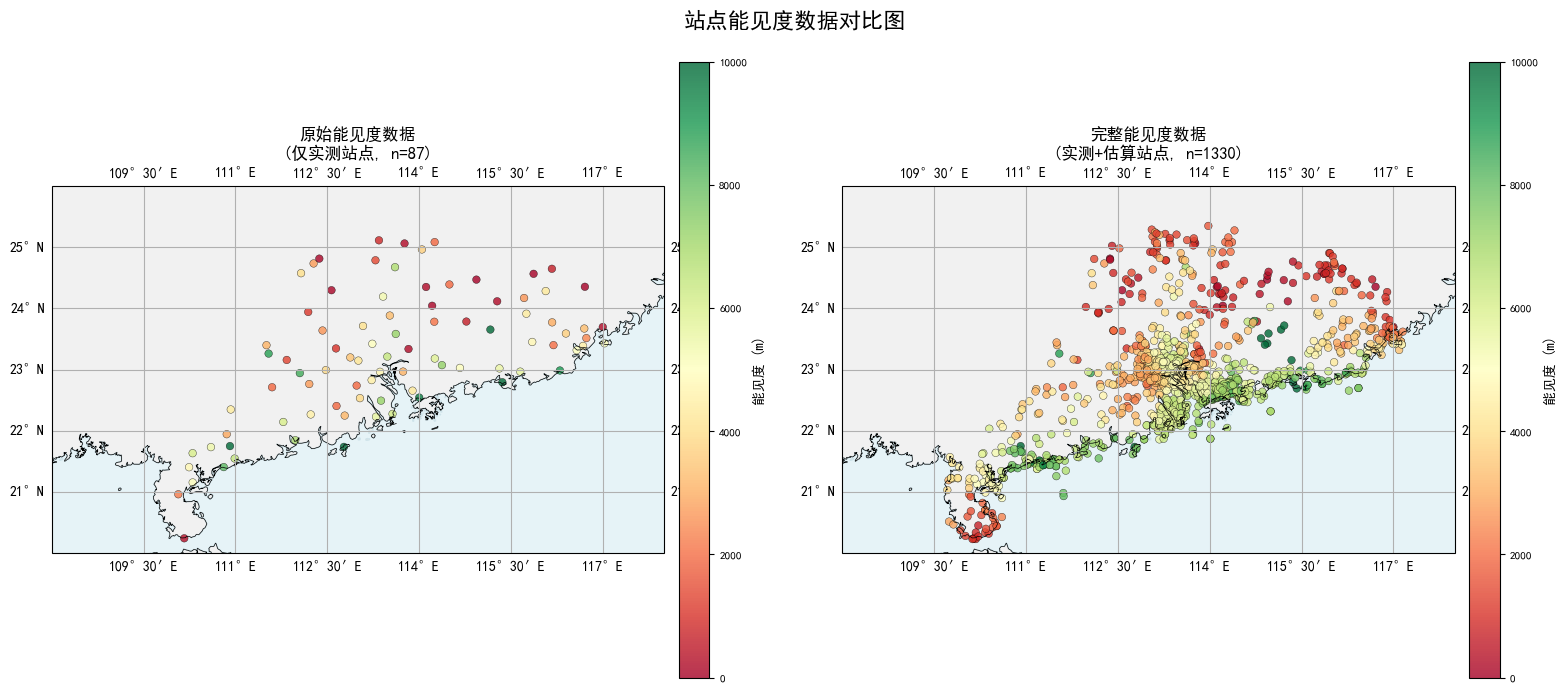

对比图绘制完成


In [26]:
# 创建对比图：原始数据 vs 完整数据
fig = plt.figure(figsize=(16, 8))

# 左图：原始station_vis数据（仅实测值）
ax1 = fig.add_subplot(1, 2, 1, projection=ccrs.PlateCarree())
scatter1 = create_visibility_map(station_vis, 
                                f'原始能见度数据\n(仅实测站点, n={len(station_vis)})', 
                                ax1, show_colorbar=True)

# 右图：完整station_vis_all数据（实测+估算）
ax2 = fig.add_subplot(1, 2, 2, projection=ccrs.PlateCarree())
scatter2 = create_visibility_map(station_vis_all, 
                                f'完整能见度数据\n(实测+估算站点, n={len(station_vis_all)})', 
                                ax2, show_colorbar=True)

plt.tight_layout()
plt.suptitle('站点能见度数据对比图', fontsize=16, fontweight='bold', y=0.95)
plt.show()

print("对比图绘制完成")


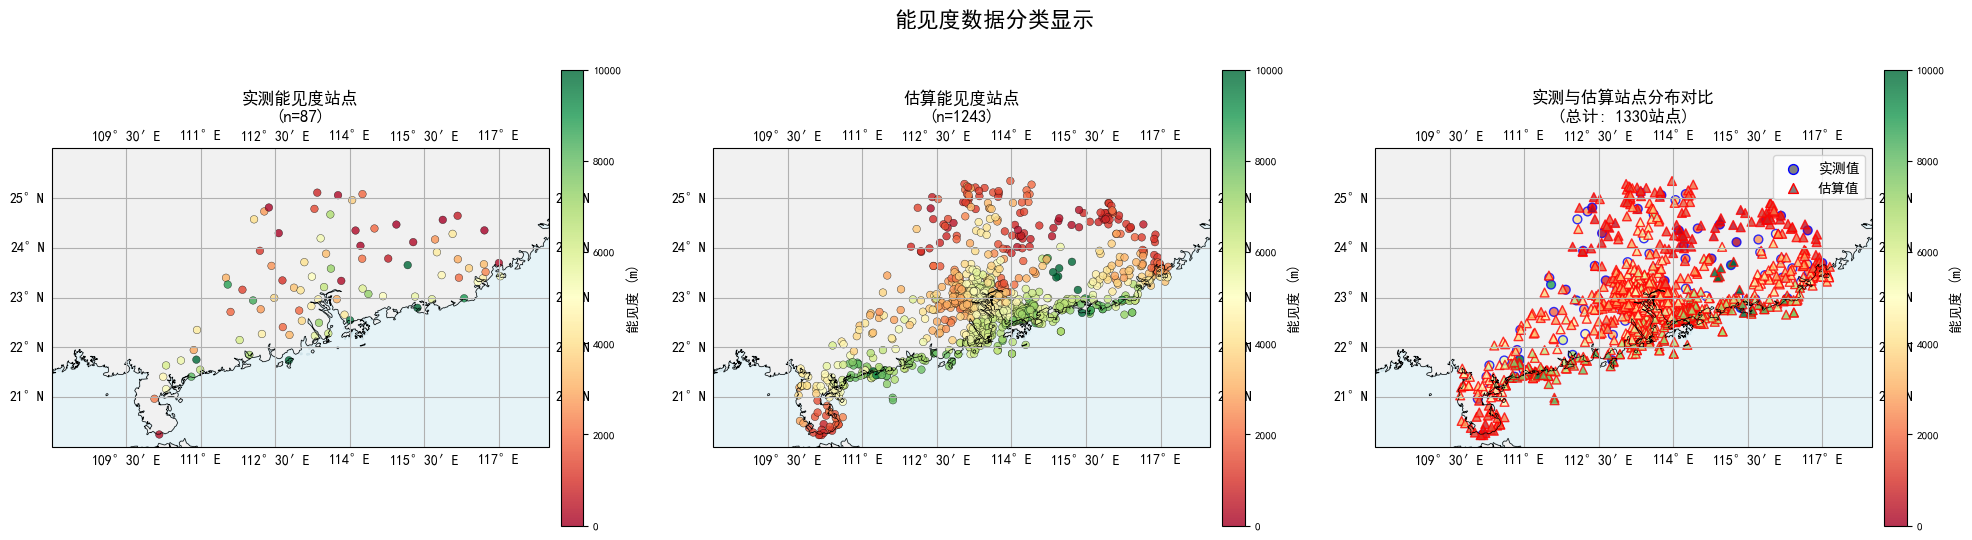

分类显示图绘制完成


In [27]:
# 创建分类显示图：按估算状态分类
fig = plt.figure(figsize=(20, 6))

# 实测站点
measured_data = station_vis_all[station_vis_all['is_vis_est'] == 0]
ax1 = fig.add_subplot(1, 3, 1, projection=ccrs.PlateCarree())
create_visibility_map(measured_data, 
                      f'实测能见度站点\n(n={len(measured_data)})', 
                      ax1, show_colorbar=True)

# 估算站点
estimated_data = station_vis_all[station_vis_all['is_vis_est'] == 1]
ax2 = fig.add_subplot(1, 3, 2, projection=ccrs.PlateCarree())
create_visibility_map(estimated_data, 
                      f'估算能见度站点\n(n={len(estimated_data)})', 
                      ax2, show_colorbar=True)

# 合并显示（用不同符号区分）
ax3 = fig.add_subplot(1, 3, 3, projection=ccrs.PlateCarree())
ax3.set_extent([108, 118, 20, 26], crs=ccrs.PlateCarree())
ax3.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax3.add_feature(cfeature.BORDERS, linewidth=0.5)
ax3.add_feature(cfeature.LAND, alpha=0.3, color='lightgray')
ax3.add_feature(cfeature.OCEAN, alpha=0.3, color='lightblue')
ax3.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

# 分别绘制实测和估算站点，用不同符号
if len(measured_data) > 0:
    measured_valid = measured_data.dropna(subset=['vis', 'lon', 'lat'])
    scatter_measured = ax3.scatter(measured_valid['lon'], measured_valid['lat'], 
                                  c=measured_valid['vis'], s=40, alpha=0.8,
                                  cmap='RdYlGn', vmin=0, vmax=10000,
                                  transform=ccrs.PlateCarree(), 
                                  marker='o', edgecolors='blue', linewidth=1,
                                  label='实测值')

if len(estimated_data) > 0:
    estimated_valid = estimated_data.dropna(subset=['vis', 'lon', 'lat'])
    scatter_estimated = ax3.scatter(estimated_valid['lon'], estimated_valid['lat'], 
                                   c=estimated_valid['vis'], s=40, alpha=0.8,
                                   cmap='RdYlGn', vmin=0, vmax=10000,
                                   transform=ccrs.PlateCarree(), 
                                   marker='^', edgecolors='red', linewidth=1,
                                   label='估算值')

# 添加图例
legend_elements = [plt.scatter([], [], marker='o', s=50, c='gray', edgecolors='blue', 
                              linewidth=1, label='实测值'),
                  plt.scatter([], [], marker='^', s=50, c='gray', edgecolors='red', 
                              linewidth=1, label='估算值')]
ax3.legend(handles=legend_elements, loc='upper right')

# 添加颜色条
if len(measured_data) > 0:
    cbar = plt.colorbar(scatter_measured, ax=ax3, shrink=0.8, pad=0.02)
    cbar.set_label('能见度 (m)', fontsize=10)
    cbar.ax.tick_params(labelsize=8)

ax3.set_title(f'实测与估算站点分布对比\n(总计: {len(station_vis_all)}站点)', 
              fontsize=12, fontweight='bold')

plt.tight_layout()
plt.suptitle('能见度数据分类显示', fontsize=16, fontweight='bold', y=0.98)
plt.show()

print("分类显示图绘制完成")


C:\Users\henry_Hill\AppData\Local\Temp\ipykernel_1596\2929577704.py:61: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax4.boxplot(data_for_box, labels=labels, patch_artist=True)


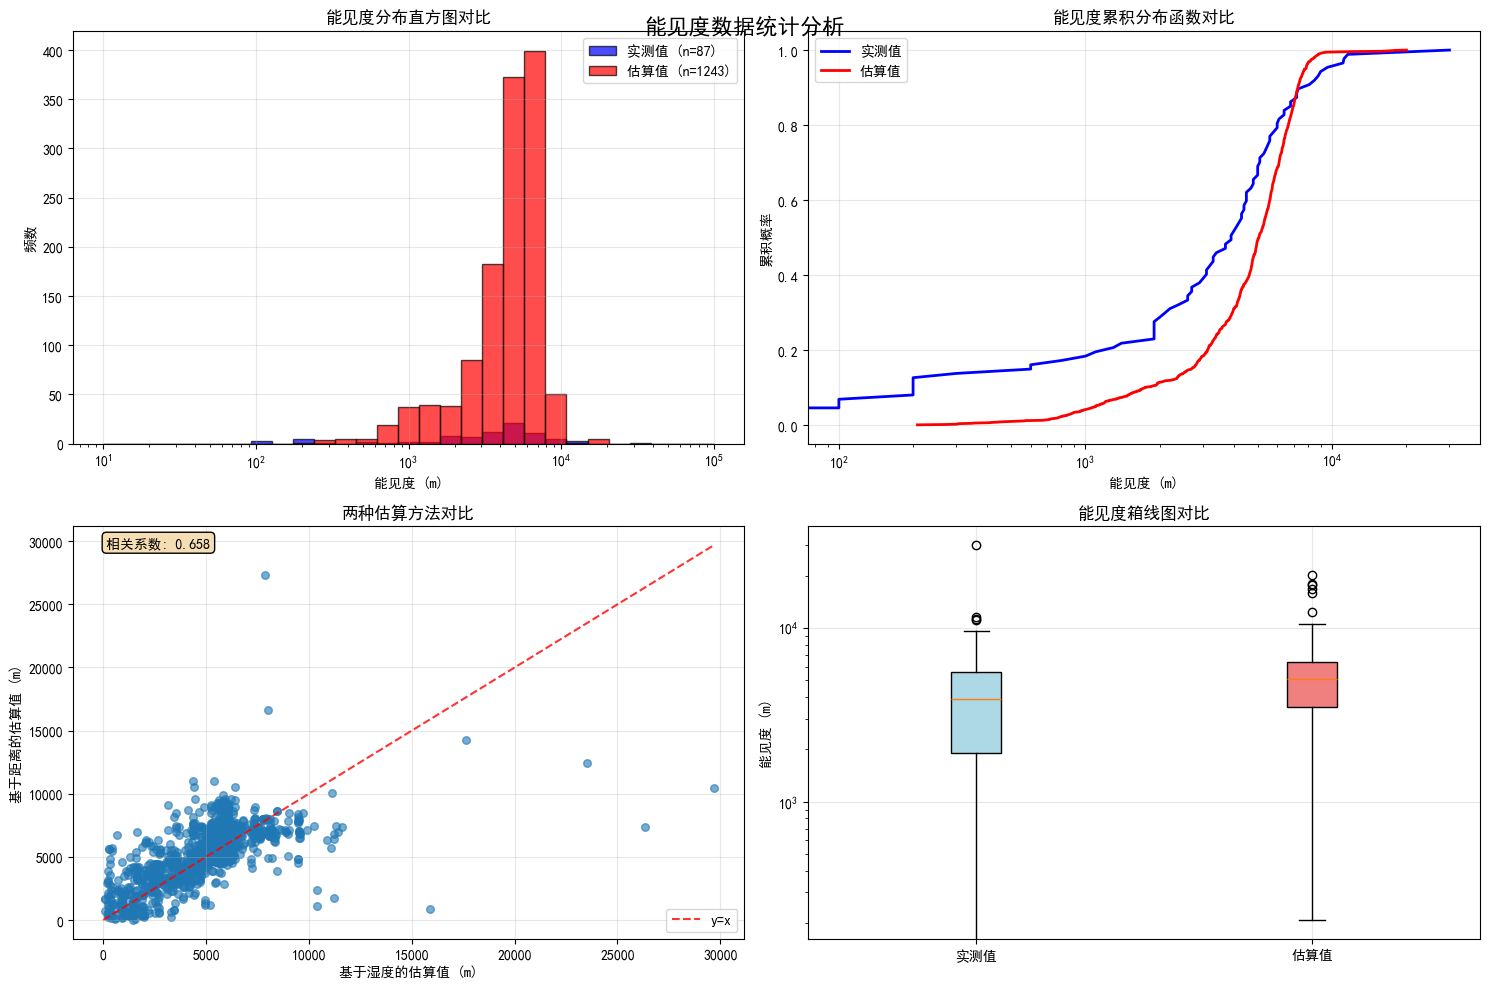

统计分析图表绘制完成


In [28]:
# 统计图表分析
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# 1. 能见度分布直方图对比
vis_measured = station_vis_all[station_vis_all['is_vis_est'] == 0]['vis'].dropna()
vis_estimated = station_vis_all[station_vis_all['is_vis_est'] == 1]['vis'].dropna()

bins = np.logspace(1, 5, 30)  # 对数刻度的bins
ax1.hist(vis_measured, bins=bins, alpha=0.7, label=f'实测值 (n={len(vis_measured)})', 
         color='blue', edgecolor='black')
ax1.hist(vis_estimated, bins=bins, alpha=0.7, label=f'估算值 (n={len(vis_estimated)})', 
         color='red', edgecolor='black')
ax1.set_xscale('log')
ax1.set_xlabel('能见度 (m)')
ax1.set_ylabel('频数')
ax1.set_title('能见度分布直方图对比')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. 累积分布函数对比
sorted_measured = np.sort(vis_measured)
sorted_estimated = np.sort(vis_estimated)
y_measured = np.arange(1, len(sorted_measured) + 1) / len(sorted_measured)
y_estimated = np.arange(1, len(sorted_estimated) + 1) / len(sorted_estimated)

ax2.plot(sorted_measured, y_measured, label='实测值', linewidth=2, color='blue')
ax2.plot(sorted_estimated, y_estimated, label='估算值', linewidth=2, color='red')
ax2.set_xscale('log')
ax2.set_xlabel('能见度 (m)')
ax2.set_ylabel('累积概率')
ax2.set_title('能见度累积分布函数对比')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. 两种估算方法的比较散点图
vis_rh_values = station_vis_all[station_vis_all['is_vis_est'] == 1]['vis_rh'].dropna()
vis_dis_values = station_vis_all[station_vis_all['is_vis_est'] == 1]['vis_dis'].dropna()

# 找到同时有两种估算值的数据点
both_valid = station_vis_all[station_vis_all['is_vis_est'] == 1].dropna(subset=['vis_rh', 'vis_dis'])
if len(both_valid) > 0:
    ax3.scatter(both_valid['vis_rh'], both_valid['vis_dis'], alpha=0.6, s=30)
    # 添加对角线
    min_val = min(both_valid['vis_rh'].min(), both_valid['vis_dis'].min())
    max_val = max(both_valid['vis_rh'].max(), both_valid['vis_dis'].max())
    ax3.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8, label='y=x')
    ax3.set_xlabel('基于湿度的估算值 (m)')
    ax3.set_ylabel('基于距离的估算值 (m)')
    ax3.set_title('两种估算方法对比')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 计算相关系数
    correlation = np.corrcoef(both_valid['vis_rh'], both_valid['vis_dis'])[0, 1]
    ax3.text(0.05, 0.95, f'相关系数: {correlation:.3f}', 
             transform=ax3.transAxes, bbox=dict(boxstyle="round", facecolor='wheat'))

# 4. 箱线图对比
data_for_box = [vis_measured, vis_estimated]
labels = ['实测值', '估算值']
bp = ax4.boxplot(data_for_box, labels=labels, patch_artist=True)
bp['boxes'][0].set_facecolor('lightblue')
bp['boxes'][1].set_facecolor('lightcoral')
ax4.set_yscale('log')
ax4.set_ylabel('能见度 (m)')
ax4.set_title('能见度箱线图对比')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('能见度数据统计分析', fontsize=16, fontweight='bold', y=0.98)
plt.show()

print("统计分析图表绘制完成")


C:\Users\henry_Hill\AppData\Local\Temp\ipykernel_1596\4259960119.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


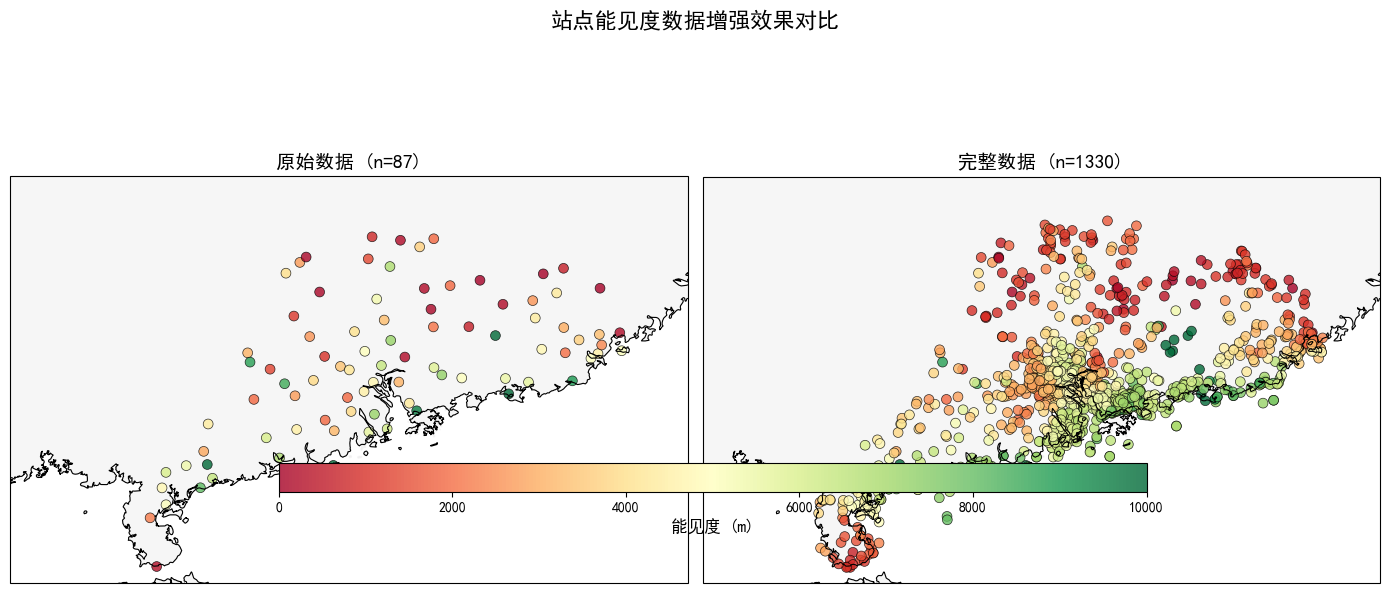


=== 可视化分析总结 ===
📊 数据增强效果:
   • 原始站点数量: 87
   • 最终站点数量: 1330
   • 增加站点数量: 1243
   • 数据增长率: 1428.7%

🎯 算法成功率:
   • 成功估算站点: 1243/1243
   • 估算成功率: 100.0%

📈 可视化图表说明:
   1. 地图对比图 - 展示站点空间分布的改善
   2. 分类显示图 - 区分实测值与估算值
   3. 统计分析图 - 对比数据分布特征
   4. 相关性分析 - 验证两种估算方法的一致性

✅ 能见度估算算法实现完成！


In [29]:
# 创建简化版的地图对比图（用于报告）
fig = plt.figure(figsize=(14, 6))

# 左图：原始数据
ax1 = fig.add_subplot(1, 2, 1, projection=ccrs.PlateCarree())
ax1.set_extent([108, 118, 20, 26], crs=ccrs.PlateCarree())
ax1.add_feature(cfeature.COASTLINE, linewidth=0.8)
ax1.add_feature(cfeature.BORDERS, linewidth=0.8)
ax1.add_feature(cfeature.LAND, alpha=0.2, color='lightgray')

vis_orig = station_vis.dropna(subset=['vis', 'lon', 'lat'])
scatter1 = ax1.scatter(vis_orig['lon'], vis_orig['lat'], 
                      c=vis_orig['vis'], s=50, alpha=0.8,
                      cmap='RdYlGn', vmin=0, vmax=10000,
                      transform=ccrs.PlateCarree(), 
                      edgecolors='black', linewidth=0.5)
ax1.set_title(f'原始数据 (n={len(vis_orig)})', fontsize=14, fontweight='bold')

# 右图：完整数据
ax2 = fig.add_subplot(1, 2, 2, projection=ccrs.PlateCarree())
ax2.set_extent([108, 118, 20, 26], crs=ccrs.PlateCarree())
ax2.add_feature(cfeature.COASTLINE, linewidth=0.8)
ax2.add_feature(cfeature.BORDERS, linewidth=0.8)
ax2.add_feature(cfeature.LAND, alpha=0.2, color='lightgray')

vis_all = station_vis_all.dropna(subset=['vis', 'lon', 'lat'])
scatter2 = ax2.scatter(vis_all['lon'], vis_all['lat'], 
                      c=vis_all['vis'], s=50, alpha=0.8,
                      cmap='RdYlGn', vmin=0, vmax=10000,
                      transform=ccrs.PlateCarree(), 
                      edgecolors='black', linewidth=0.5)
ax2.set_title(f'完整数据 (n={len(vis_all)})', fontsize=14, fontweight='bold')

# 添加共享的颜色条
cbar = fig.colorbar(scatter2, ax=[ax1, ax2], orientation='horizontal', 
                   shrink=0.8, pad=0.08, aspect=30)
cbar.set_label('能见度 (m)', fontsize=12)

plt.suptitle('站点能见度数据增强效果对比', fontsize=16, fontweight='bold')
plt.tight_layout()

# 可选：保存图片
save_figure = False  # 设置为True时保存图片
if save_figure:
    plt.savefig('../data/visibility_comparison.png', dpi=300, bbox_inches='tight')
    print("图片已保存至: ../data/visibility_comparison.png")

plt.show()

print("\n=== 可视化分析总结 ===")
print(f"📊 数据增强效果:")
print(f"   • 原始站点数量: {len(station_vis)}")
print(f"   • 最终站点数量: {len(station_vis_all)}")
print(f"   • 增加站点数量: {len(station_vis_all) - len(station_vis)}")
print(f"   • 数据增长率: {((len(station_vis_all) - len(station_vis)) / len(station_vis) * 100):.1f}%")

print(f"\n🎯 算法成功率:")
successful_estimates = len(station_vis_all[station_vis_all['is_vis_est'] == 1]['vis'].dropna())
total_estimates = len(station_vis_all[station_vis_all['is_vis_est'] == 1])
print(f"   • 成功估算站点: {successful_estimates}/{total_estimates}")
print(f"   • 估算成功率: {(successful_estimates/total_estimates * 100):.1f}%")

print(f"\n📈 可视化图表说明:")
print("   1. 地图对比图 - 展示站点空间分布的改善")
print("   2. 分类显示图 - 区分实测值与估算值")
print("   3. 统计分析图 - 对比数据分布特征")
print("   4. 相关性分析 - 验证两种估算方法的一致性")

print("\n✅ 能见度估算算法实现完成！")
